In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# File paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'
DS_LIST = ['facs']

# Score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000'}

DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST = {'facs': ['PASS_Type_2_Diabetes',
                           'PASS_Intelligence_SavageJansen2018']}

In [3]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)   

### Get data for only hepatocytes and rerun harmony+umap

In [10]:
# temp_df = pd.DataFrame(index=adata.obs_names[adata.obs['leiden']!='5'])
# temp_df.to_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/pan_b_tms_cell.tsv')

facs


2021-06-06 22:47:06,431 - harmonypy - INFO - Iteration 1 of 20
2021-06-06 22:47:06,611 - harmonypy - INFO - Iteration 2 of 20
2021-06-06 22:47:06,789 - harmonypy - INFO - Iteration 3 of 20
2021-06-06 22:47:06,960 - harmonypy - INFO - Iteration 4 of 20
2021-06-06 22:47:07,099 - harmonypy - INFO - Iteration 5 of 20
2021-06-06 22:47:07,222 - harmonypy - INFO - Iteration 6 of 20
2021-06-06 22:47:07,312 - harmonypy - INFO - Iteration 7 of 20
2021-06-06 22:47:07,387 - harmonypy - INFO - Iteration 8 of 20
2021-06-06 22:47:07,478 - harmonypy - INFO - Iteration 9 of 20
2021-06-06 22:47:07,569 - harmonypy - INFO - Iteration 10 of 20
2021-06-06 22:47:07,652 - harmonypy - INFO - Iteration 11 of 20
2021-06-06 22:47:07,735 - harmonypy - INFO - Iteration 12 of 20
2021-06-06 22:47:07,818 - harmonypy - INFO - Iteration 13 of 20
2021-06-06 22:47:07,892 - harmonypy - INFO - Converged after 13 iterations
... storing 'tissue_celltype' as categorical


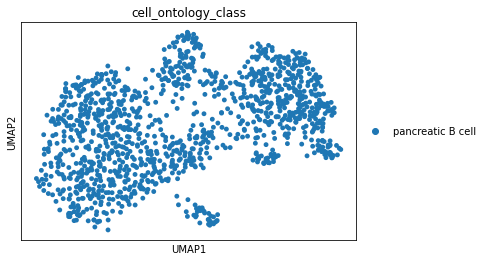

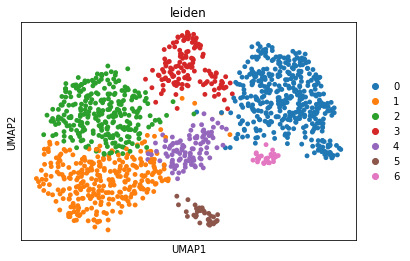

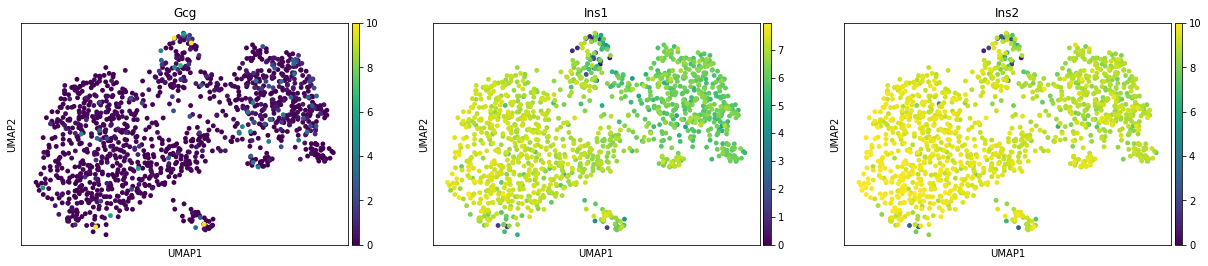

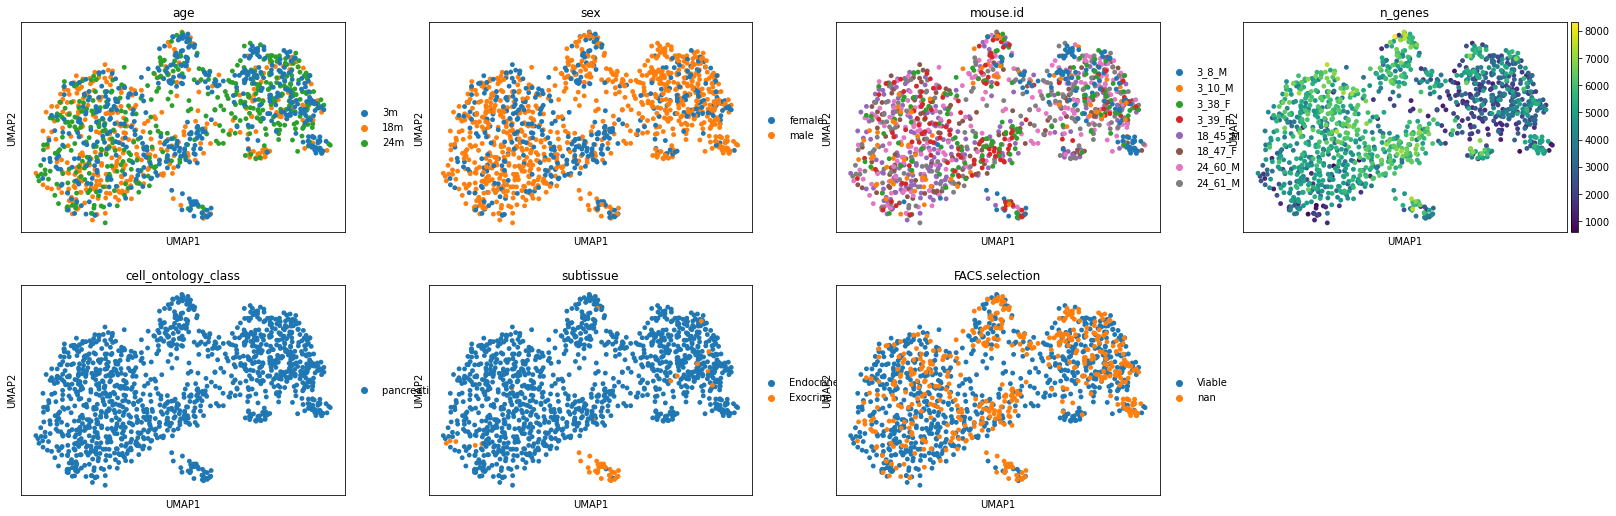

In [15]:
# Reprocess t cell data
dic_data_proc = {}
for ds in DS_LIST:
    print(ds)
#     ind_select = (dic_data_raw[ds].obs['cell_ontology_class']=='pancreatic B cell') 
#     adata = dic_data_raw[ds][ind_select,:].copy()
    cell_list = list(pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                 'pan_b_tms_cell.tsv')['index'])
    adata = dic_data_raw[ds][cell_list,:].copy()
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=50)
    adata.obs['batch_harmony'] = adata.obs['mouse.id']
    adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                                min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
    sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
#     sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca")
    sc.tl.leiden(adata, resolution=0.7)   
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='cell_ontology_class')
    sc.pl.umap(adata, color='leiden')
    sc.pl.umap(adata, color=['Gcg', 'Ins1', 'Ins2'])
    sc.pl.umap(adata, color=['age', 'sex', 'mouse.id', 'n_genes', 
                             'cell_ontology_class', 'subtissue', 'FACS.selection'])
    adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                'pan_b.%s.h5ad'%ds)

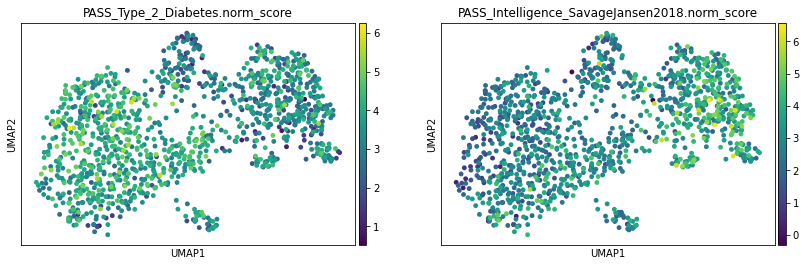

In [16]:
temp_data = adata.copy()
temp_data.obs = temp_data.obs.join(dic_score[ds][['%s.norm_score'%x for x in DIC_TRAIT_LIST[ds]]])
sc.pl.umap(temp_data, color=['%s.norm_score'%x for x in DIC_TRAIT_LIST[ds]])